In [13]:
# import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
from scipy import signal
import scipy
import os, sys, pickle, gzip
import datetime
# import geopy.distance
import xarray as xr
import pandas as pd
# import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.util import add_cyclic_point
import itertools
import random
# import metpy
# from metpy.plots import USCOUNTIES
import xgrid_utils

from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress

import warnings
warnings.filterwarnings('ignore')

In [14]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [15]:
cmip6_models = ['access-cm2', 'awi-esm-1-1-lr', 'bcc-csm2-mr',
                'bcc-esm1', 'canesm5', 'cmcc-esm2',
                'fgoals-f3-l', 'fgoals-g3', 'inm-cm4-8',
                'inm-cm5-0', 'ipsl-cm6a-lr', 'kace-1-0-g',
                'miroc6', 'mpi-esm1-2-hr', 'mpi-esm1-2-lr',
                'mri-esm2-0', 'noresm2-lm', 'taiesm1']
# cmip6_models = ['taiesm1']

cmip6_lat = np.arange(-90, 90, 1.5)
cmip6_lon = np.arange(0, 360, 1.5)

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})

# model = cmip6_models[7]

In [16]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirEra5Land = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5-Land'
dirCMIP6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirUtil = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/util'
dataDirLens = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Data-edcoffel-F20/LENS/daily/atm'

In [17]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
land_sea_mask = land_sea_mask.lsm.mean(dim='time')
land_sea_mask_binary = land_sea_mask > 0.1


In [22]:
tw = xr.open_mfdataset(f"{dirCMIP6}/access-cm2/r1i1p1f1/ssp245/tw/tw_daily*.nc", concat_dim='time')

In [23]:
tw_mean = xgrid_utils.calc_spatial_mean(tw.tw.rename({'lat':'latitude', 'lon':'longitude'}))

In [24]:
tw_mean.load()

<xarray.DataArray 'tw' (time: 13880)>
array([2.64333043, 2.63987753, 2.71068448, ..., 3.78438221, 3.70318457,
       3.62407859])
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2060-12-31T12:00:00

In [31]:
tw_mean.resample(time='1Y').mean()

<xarray.DataArray 'tw' (time: 46)>
array([4.98268872, 4.88023607, 4.98205947, 5.0123716 , 4.95080122,
       4.99458422, 5.00420739, 5.17408191, 5.12277492, 5.09670388,
       5.20429493, 5.16081503, 5.24863595, 5.24653252, 5.26822906,
              nan, 5.24650481, 5.18732652, 5.30411431, 5.30882922,
       5.37713666, 5.22564811, 5.29627334, 5.48852003, 5.41174041,
       5.5852745 , 5.4942307 , 5.6028536 , 5.66566633,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 5.716668  , 5.67265256, 5.87523554, 5.75691402,
       5.89850477, 5.90797713, 5.79666928, 5.88253574, 6.06141726,
       5.76188594])
Coordinates:
  * time     (time) datetime64[ns] 2015-12-31 2016-12-31 ... 2060-12-31
    height   float64 2.0

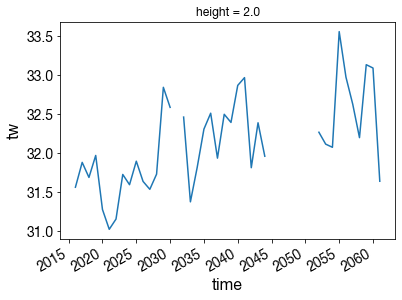

In [29]:
tw.tw.max(dim=['lat', 'lon']).resample(time='1Y').max().plot()

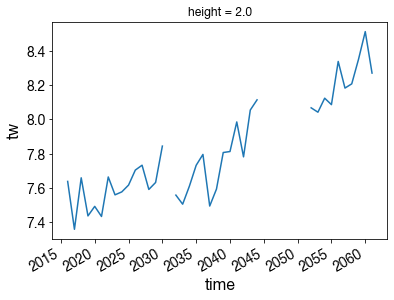

In [25]:
tw_mean.resample(time='1Y').max().plot()

In [122]:
era5_tx_on_tx_ts = xr.open_dataset('intermediate/tx_on_tx_ts.nc')
era5_tw_on_tx_ts = xr.open_dataset('intermediate/tw_on_tx_ts.nc')
era5_tw_on_tw_ts = xr.open_dataset('intermediate/tw_on_tw_ts.nc')
era5_tx_on_tw_ts = xr.open_dataset('intermediate/tx_on_tw_ts.nc')

In [123]:
x = np.arange(era5_tx_on_tw_ts.mx2t[0:-1,-1].shape[0])
era5_tx_tw_minus_tx_tx = (era5_tx_on_tw_ts.mx2t[0:-1,-1])-era5_tx_on_tx_ts.mx2t[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tx_tw_minus_tx_tx.values,X).fit()
era5_tx_tw_vs_tx_tx_trend = mdl.params[1]*10
era5_tx_tw_vs_tx_tx_pval = mdl.pvalues[1]

era5_tw_tx_minus_tw_tw = (era5_tw_on_tx_ts.tw[:,-1])-era5_tw_on_tw_ts.tw[:,-1]

X = sm.add_constant(x)
mdl = sm.OLS(era5_tw_tx_minus_tw_tw.values,X).fit()
era5_tw_tx_vs_tw_tw_trend = mdl.params[1]*10
era5_tw_tx_vs_tw_tw_pval = mdl.pvalues[1]

In [124]:
tx_on_tww_ds = []
tx_on_txx_ds = []
tw_on_tww_ds = []
tw_on_txx_ds = []

# Loop through each model
for model in cmip6_models:
    # Construct the filename
    filename = f'output/cmip6/tx_on_tww_{model}.nc'
    
    # Open the dataset and append to the list
    ds = xr.open_dataset(filename)
    tx_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tx_on_txx_{model}.nc'
    ds = xr.open_dataset(filename)
    tx_on_txx_ds.append(ds)

    filename = f'output/cmip6/tw_on_tww_{model}.nc'
    ds = xr.open_dataset(filename)
    tw_on_tww_ds.append(ds)
    
    filename = f'output/cmip6/tw_on_txx_{model}.nc'
    ds = xr.open_dataset(filename)
    tw_on_txx_ds.append(ds)

    
# Concatenate all datasets along the 'model' dimension
tx_on_tww_ds = xr.concat(tx_on_tww_ds, dim='model')
tx_on_tww_ds['model'] = cmip6_models  
tx_on_tww_ds = tx_on_tww_ds.rename({'__xarray_dataarray_variable__':'tx_on_tww'})

tx_on_txx_ds = xr.concat(tx_on_txx_ds, dim='model')
tx_on_txx_ds['model'] = cmip6_models  
tx_on_txx_ds = tx_on_txx_ds.rename({'__xarray_dataarray_variable__':'tx_on_txx'})

tw_on_tww_ds = xr.concat(tw_on_tww_ds, dim='model')
tw_on_tww_ds['model'] = cmip6_models  
tw_on_tww_ds = tw_on_tww_ds.rename({'__xarray_dataarray_variable__':'tw_on_tww'})

tw_on_txx_ds = xr.concat(tw_on_txx_ds, dim='model')
tw_on_txx_ds['model'] = cmip6_models  
tw_on_txx_ds = tw_on_txx_ds.rename({'__xarray_dataarray_variable__':'tw_on_txx'})

In [125]:
tx_on_txx_ds = tx_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tx_on_tww_ds = tx_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_txx_ds = tw_on_txx_ds.rename({'lat':'latitude', 'lon':'longitude'})
tw_on_tww_ds = tw_on_tww_ds.rename({'lat':'latitude', 'lon':'longitude'})

cmip6_tx_tw_minus_tx_tx_spatial_mean = xgrid_utils.calc_spatial_mean(tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx)
cmip6_tw_tx_minus_tw_tw_spatial_mean = xgrid_utils.calc_spatial_mean(tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww)



In [126]:
# Calculate the spatial average for each model and time
# cmip6_tx_tw_minus_tx_tx_spatial_mean = (tx_on_tww_ds.tx_on_tww - tx_on_txx_ds.tx_on_txx).mean(dim=['lat', 'lon'])
# cmip6_tw_tx_minus_tw_tw_spatial_mean = (tw_on_txx_ds.tw_on_txx - tw_on_tww_ds.tw_on_tww).mean(dim=['lat', 'lon'])

# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    x = np.arange(len(y))
    X = sm.add_constant(x)  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y, X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
cmip6_tx_tw_minus_tx_tx_slopes = []
cmip6_tx_tw_minus_tx_tx_pvals = []

cmip6_tw_tx_minus_tw_tw_slopes = []
cmip6_tw_tx_minus_tw_tw_pvals = []

for model in cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values:
    model_data = cmip6_tx_tw_minus_tx_tx_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tx_tw_minus_tx_tx_slopes.append(slope*10)
    cmip6_tx_tw_minus_tx_tx_pvals.append(pval)
    
    model_data = cmip6_tw_tx_minus_tw_tw_spatial_mean.sel(model=model).values
    slope, pval = calculate_ols_slope(model_data)
    cmip6_tw_tx_minus_tw_tw_slopes.append(slope*10)
    cmip6_tw_tx_minus_tw_tw_pvals.append(pval)

cmip6_tx_tw_minus_tx_tx_slopes = xr.DataArray(cmip6_tx_tw_minus_tx_tx_slopes, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])
cmip6_tx_tw_minus_tx_tx_pvals = xr.DataArray(cmip6_tx_tw_minus_tx_tx_pvals, coords=[cmip6_tx_tw_minus_tx_tx_spatial_mean.model.values], dims=['model'])

cmip6_tw_tx_minus_tw_tw_slopes = xr.DataArray(cmip6_tw_tx_minus_tw_tw_slopes, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])
cmip6_tw_tx_minus_tw_tw_pvals = xr.DataArray(cmip6_tw_tx_minus_tw_tw_pvals, coords=[cmip6_tw_tx_minus_tw_tw_spatial_mean.model.values], dims=['model'])



Text(0, 0.5, 'Global mean\nTx|Tw - $Tx_{100}$ trend\n($\\degree$C per decade)')

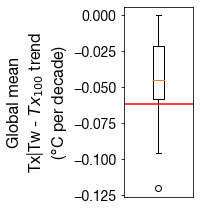

In [127]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(cmip6_tx_tw_minus_tx_tx_slopes)
plt.plot([.5, 1.5], [era5_tx_tw_vs_tx_tx_trend, era5_tx_tw_vs_tx_tx_trend], '-r')
plt.xticks([])
plt.ylabel('Global mean\nTx|Tw - $Tx_{100}$ trend\n($\degree$C per decade)')

Text(0, 0.5, 'Global mean\nTw|Tx - $Tw_{100}$ trend\n($\\degree$C per decade)')

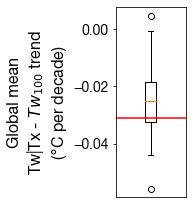

In [128]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(cmip6_tw_tx_minus_tw_tw_slopes)
plt.plot([.5, 1.5], [era5_tw_tx_vs_tw_tw_trend, era5_tw_tx_vs_tw_tw_trend], '-r')
plt.xticks([])
plt.ylabel('Global mean\nTw|Tx - $Tw_{100}$ trend\n($\degree$C per decade)')

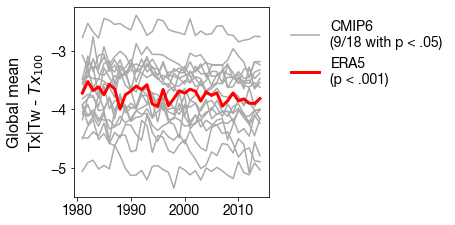

In [129]:
plt.figure(figsize=(3.5,3.5))

plt.plot(np.arange(1981,2015), cmip6_tx_tw_minus_tx_tx_spatial_mean.T[:,0], c='#aaaaaa', label='CMIP6\n(%d/%d with p < .05)'%(np.where(cmip6_tx_tw_minus_tx_tx_pvals.values<.05)[0].size, cmip6_tx_tw_minus_tx_tx_pvals.size))
plt.plot(np.arange(1981,2015), cmip6_tx_tw_minus_tx_tx_spatial_mean.T[:,1:], c='#aaaaaa')
plt.plot(np.arange(1981,2015), era5_tx_tw_minus_tx_tx[0:34], c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nTx|Tw - $Tx_{100}$')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

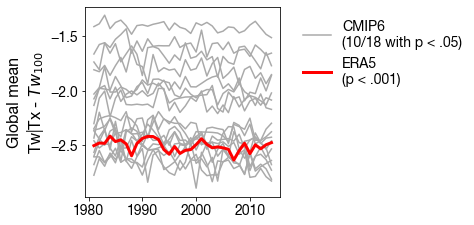

In [130]:
plt.figure(figsize=(3.5,3.5))

plt.plot(np.arange(1981,2015), cmip6_tw_tx_minus_tw_tw_spatial_mean.T[:,0], c='#aaaaaa', label='CMIP6\n(%d/%d with p < .05)'%(np.where(cmip6_tw_tx_minus_tw_tw_pvals.values<.05)[0].size, cmip6_tw_tx_minus_tw_tw_pvals.size))
plt.plot(np.arange(1981,2015), cmip6_tw_tx_minus_tw_tw_spatial_mean.T[:,1:], c='#aaaaaa')
plt.plot(np.arange(1981,2015), era5_tw_tx_minus_tw_tw[0:34], c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nTw|Tx - $Tw_{100}$')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

In [132]:
# Initialize a list to store the monthly means for each ensemble member
lens_tx_tw_ensemble_members = []

n_members = 33

# Loop through ensemble members from 1-10
for i in range(1, n_members+1):
    # Load the data for the current ensemble member
    tx_tw_corr_lens = xr.open_dataset(f'tx_tw_corr_lens_member_{i}.nc')
    tx_tw_corr_lens = tx_tw_corr_lens.rename({'__xarray_dataarray_variable__': 'tw'})
    
    tx_tw_corr_lens.load()
    
    # Append the monthly mean to the list
    lens_tx_tw_ensemble_members.append(tx_tw_corr_lens)

# Concatenate along the 'ensemble' dimension
lens_tx_tw_ensemble_members = xr.concat(lens_tx_tw_ensemble_members, dim='ensemble')
lens_tx_tw_ensemble_members['ensemble'] = np.arange(1, n_members+1)  # Assign ensemble member numbers to the 'ensemble' coordinate
lens_tx_tw_ensemble_members = lens_tx_tw_ensemble_members.rename({'lat':'latitude', 'lon':'longitude'})

In [133]:
lens_tx_tw_ensemble_members_spatial_mean = xgrid_utils.calc_spatial_mean(lens_tx_tw_ensemble_members.sel(latitude=slice(-60, 60)))

In [139]:
# Function to calculate the linear trend's slope using statsmodels OLS
def calculate_ols_slope(y):
    nn = np.where(~np.isnan(y))[0]
    x = np.arange(len(y))
    X = sm.add_constant(x[nn])  # Add a constant (i.e., bias or intercept) to the independent variable
    model = sm.OLS(y[nn], X).fit()
    return model.params[1], model.pvalues[1]  # This returns the slope

# Calculate the linear trend for each model
lens_tx_tw_corr_slopes = []
lens_tx_tw_corr_pvals = []

for i in lens_tx_tw_ensemble_members_spatial_mean.ensemble.values:
    model_data = lens_tx_tw_ensemble_members_spatial_mean.tw.sel(ensemble=i).values
    slope, pval = calculate_ols_slope(model_data)
    lens_tx_tw_corr_slopes.append(slope*10)
    lens_tx_tw_corr_pvals.append(pval)
    
lens_tx_tw_corr_slopes = xr.DataArray(lens_tx_tw_corr_slopes, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])
lens_tx_tw_corr_pvals = xr.DataArray(lens_tx_tw_corr_pvals, coords=[lens_tx_tw_ensemble_members_spatial_mean.ensemble.values], dims=['ensemble'])


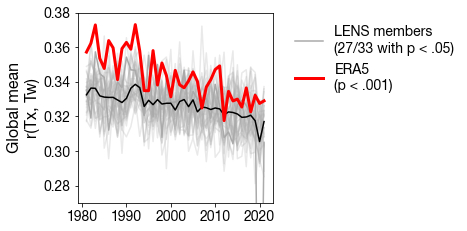

In [150]:
plt.figure(figsize=(3.5,3.5))
plt.ylim([.27, .38])

plt.plot(np.arange(1981,2021+1), lens_tx_tw_ensemble_members_spatial_mean.tw.values.T[:,0], c='#aaaaaa', alpha=1, label='LENS members\n(%d/%d with p < .05)'%(np.where(lens_tx_tw_corr_pvals<.05)[0].size, lens_tx_tw_corr_pvals.size))
plt.plot(np.arange(1981,2021+1), lens_tx_tw_ensemble_members_spatial_mean.tw.values.T[:,1:], c='#aaaaaa', alpha=.25)
plt.plot(np.arange(1981,2021+1), np.nanmean(lens_tx_tw_ensemble_members_spatial_mean.tw.values.T, axis=1), c='k')
plt.plot(np.arange(1981,2021+1), tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')


plt.xticks([1980, 1990, 2000, 2010, 2020])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

([], [])

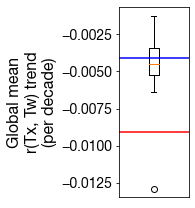

In [155]:
plt.figure(figsize=(1.25,3.5))
# plt.ylim([-.012, 0]?)
plt.boxplot(lens_tx_tw_corr_slopes)
plt.plot([.5, 1.5], [obs_slope, obs_slope], '-r')
plt.plot([.5, 1.5], [np.nanmean(corr_ts_slopes), np.nanmean(corr_ts_slopes)], '-b')
plt.ylabel('Global mean\nr(Tx, Tw) trend\n(per decade)')
plt.xticks([])

In [110]:
# LOAD ERA5 TX_TW_CORR MEAN

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
tx_tw_corr_full = xr.open_mfdataset('output/tx_tw_corr/tx_tw_corr_warm_season_*.nc', preprocess = add_time_dim, concat_dim='time')
tx_tw_corr_full['time'] = time_dim
tx_tw_corr_full = tx_tw_corr_full.sel(time=slice('1981-01-01', '2021-12-31'))

tx_tw_corr_full = tx_tw_corr_full.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
tx_tw_corr_full = tx_tw_corr_full.where(land_sea_mask_binary)
tx_tw_corr_full.load()
tx_tw_corr_mean = tx_tw_corr_full.mean(dim='time')

tx_tw_corr_ts = xgrid_utils.calc_spatial_mean(tx_tw_corr_full.sel(latitude=slice(60,-60)))

In [111]:
# Load the DataArray containing the months of annual maximum temperature
annual_max_months_da_tx = xr.open_dataarray("txx_months_1981_2021.nc")
annual_max_months_da_tx.load();
annual_max_months_da_tw = xr.open_dataarray("tw_months_1981_2021.nc")
annual_max_months_da_tw.load();
annual_max_months_da_tx = annual_max_months_da_tx.rename({'latitude':'lat', 'longitude':'lon'})

In [ ]:
# # REGRID ALL THE CMIP6 MODELS and CALC TX_TW CORR

# for model in cmip6_models:
#     print('opening %s'%model)
#     cmip6_tw = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tw/*.nc'%(dirCMIP6, model))
#     cmip6_tx = xr.open_mfdataset('%s/%s/r1i1p1f1/historical/tasmax/*day*.nc'%(dirCMIP6, model))
    
#     cmip6_tx = cmip6_tx.sel(time=slice('1981', '2014'))
#     cmip6_tw = cmip6_tw.sel(time=slice('1981', '2014'))
    
#     cmip6_tx = cmip6_tx['tasmax']
#     cmip6_tx = cmip6_tx.reindex(lat=cmip6_tx.lat[::-1])
#     cmip6_tx.load();

#     cmip6_tw = cmip6_tw['tw']
#     cmip6_tw = cmip6_tw.reindex(lat=cmip6_tw.lat[::-1])
#     cmip6_tw.load();
    
#     print('regridding...')
#     regridder = xe.Regridder(land_sea_mask_binary.rename({'latitude':'lat', 'longitude':'lon'}), regridMesh_global, 'bilinear', reuse_weights=True)
#     land_sea_mask_binary_regrid = regridder(land_sea_mask_binary)
    
#     regridder = xe.Regridder(cmip6_tx, regridMesh_global, 'bilinear', reuse_weights=False)
#     cmip6_tx_regrid = regridder(cmip6_tx)
#     cmip6_tw_regrid = regridder(cmip6_tw)

#     cmip6_tx_regrid = cmip6_tx_regrid.where(land_sea_mask_binary_regrid)
#     cmip6_tw_regrid = cmip6_tw_regrid.where(land_sea_mask_binary_regrid)

#     cmip6_tx_regrid = cmip6_tx_regrid.sel(lat=slice(-60,60))
#     cmip6_tw_regrid = cmip6_tw_regrid.sel(lat=slice(-60,60))
    
#     regridder = xe.Regridder(annual_max_months_da_tx, regridMesh_global, 'bilinear', reuse_weights=True)
#     annual_max_months_da_tx_regrid = regridder(annual_max_months_da_tx)
#     annual_max_months_da_tw_regrid = regridder(annual_max_months_da_tw)
    
#     print('creating warm season mask')
#     # First create a boolean mask
#     mask = xr.full_like(cmip6_tx.time, False, dtype=bool)

#     # Iterate over the years
#     for y in annual_max_months_da_tx_regrid.year:
#         # Find the month of max temperature in this year
#         month_of_max_tx = annual_max_months_da_tx_regrid.sel(year=y)
#         month_of_max_tw = annual_max_months_da_tw_regrid .sel(year=y)

#         # Set True in the mask for all days of this month in this year
#         mask = mask | (cmip6_tx_regrid.time.dt.month == month_of_max_tx) | (cmip6_tx_regrid.time.dt.month == month_of_max_tw)


#     # Apply the mask to select temperature data for the months of interest
#     cmip6_tx_regrid = cmip6_tx_regrid.where(mask, drop=True)
#     cmip6_tw_regrid = cmip6_tw_regrid.where(mask, drop=True)
    
#     print('calculating correlation...')
#     correlation_per_year = []

#     # Iterate over the years
#     for y in range(1981, 2014 + 1):
#         # Select data for this year
#         cmip6_tx_year = cmip6_tx_regrid.sel(time=cmip6_tx_regrid.time.dt.year == y)
#         cmip6_tw_year = cmip6_tw_regrid.sel(time=cmip6_tw_regrid.time.dt.year == y)

# #         print(y)
#         # Calculate the correlation for this year and store it in the list
#         correlation = xr.corr(cmip6_tx_year, cmip6_tw_year, dim='time')
#         correlation['year'] = y  # Add a coordinate for the year
#         correlation_per_year.append(correlation)

#     # Combine all the DataArrays along the 'year' dimension
#     correlation_per_year_da = xr.concat(correlation_per_year, dim='year')
    
#     print('saving file...')
#     correlation_per_year_da.to_netcdf('tx_tw_corr_%s.nc'%model)
    
    

In [112]:
tx_tw_corr_mean_regrid = tx_tw_corr_mean.rename({'latitude':'lat', 'longitude':'lon'})
regridder = xe.Regridder(tx_tw_corr_mean_regrid, regridMesh_global, 'bilinear', reuse_weights=False)
tx_tw_corr_mean_regrid = regridder(tx_tw_corr_mean_regrid.tx_tw_corr)
tx_tw_corr_mean_regrid = tx_tw_corr_mean_regrid.sel(lat=slice(-60,60))

Overwrite existing file: bilinear_721x1440_120x240.nc 
 You can set reuse_weights=True to save computing time.


In [113]:
corr_spatial = []
corr_ts = []
corr_ts_slopes = []
corr_ts_pvals = []


obs_slope = 0
nn = np.where((~np.isnan(tx_tw_corr_ts.tx_tw_corr.values)))[0]
X = sm.add_constant(range(nn.size))
mdl = sm.OLS(tx_tw_corr_ts.tx_tw_corr.values[nn], X).fit()
obs_slope = mdl.params[1]*10
obs_pval = mdl.pvalues[1]

for model in cmip6_models:
    cur_tx_tw_corr = xr.open_dataset('tx_tw_corr_%s.nc'%model)
    cur_tx_tw_corr.load()
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
    cur_tx_tw_corr = cur_tx_tw_corr.rename({'lat':'latitude', 'lon':'longitude'})
    cur_corr_ts = xgrid_utils.calc_spatial_mean(cur_tx_tw_corr.tx_tw_corr)
#     cur_corr_ts = cur_tx_tw_corr.tx_tw_corr.mean(dim=['lat', 'lon']).values
    corr_ts.append(cur_corr_ts.values)
    
    nn = np.where((~np.isnan(cur_corr_ts)))[0]
    X = sm.add_constant(cur_tx_tw_corr.year.values[nn])
    mdl = sm.OLS(cur_corr_ts[nn].values, X).fit()
    corr_ts_slopes.append(mdl.params[1]*10)
    corr_ts_pvals.append(mdl.pvalues[1])
    
    # Assign the model as a coordinate in the current data array
    cur_tx_tw_corr = cur_tx_tw_corr.assign_coords(model=model)

    # Add the current data array to the list
    corr_spatial.append(cur_tx_tw_corr)

# Concatenate along the new dimension 'model'
corr_spatial = xr.concat(corr_spatial, dim='model')
corr_ts = np.array(corr_ts)

In [114]:
cmip6_tx_tw_corr_detrend = np.full(corr_ts.shape, np.nan)
cmip6_tx_tw_minus_tx_tx_detrend = np.full(cmip6_tx_tw_minus_tx_tx_spatial_mean.shape, np.nan)
cmip6_tw_tx_minus_tw_tw_detrend = np.full(cmip6_tw_tx_minus_tw_tw_spatial_mean.shape, np.nan)

cmip6_tx_tw_minus_tx_tx_r2 = np.full([len(cmip6_models)], np.nan)
cmip6_tw_tx_minus_tw_tw_r2 = np.full([len(cmip6_models)], np.nan)

for m in range(len(cmip6_models)):
    cmip6_tx_tw_corr_detrend[m,:] = signal.detrend(corr_ts[m,:])
    cmip6_tx_tw_minus_tx_tx_detrend[m,:] = signal.detrend(cmip6_tx_tw_minus_tx_tx_spatial_mean[m,:])
    cmip6_tw_tx_minus_tw_tw_detrend[m,:] = signal.detrend(cmip6_tw_tx_minus_tw_tw_spatial_mean[m,:])
    
    X = sm.add_constant(cmip6_tx_tw_corr_detrend[m, :])
    mdl_tx_tw_minus_tx_tx = sm.OLS(cmip6_tx_tw_minus_tx_tx_detrend[m, :], X).fit()
    mdl_tw_tx_minus_tw_tw = sm.OLS(cmip6_tw_tx_minus_tw_tw_detrend[m, :], X).fit()
    
    cmip6_tx_tw_minus_tx_tx_r2[m] = mdl_tx_tw_minus_tx_tx.rsquared
    cmip6_tw_tx_minus_tw_tw_r2[m] = mdl_tw_tx_minus_tw_tw.rsquared


Text(0.5, 0, '$R^2$ between global mean\nr(T, ET) and Tx | $Tw_{100}$ - $Tx_{100}$')

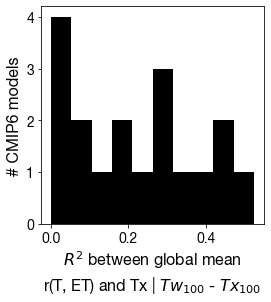

In [115]:
plt.figure(figsize=(4,4))
plt.hist(cmip6_tx_tw_minus_tx_tx_r2, color='k')

plt.ylabel('# CMIP6 models')
plt.xlabel('$R^2$ between global mean\nr(T, ET) and Tx | $Tw_{100}$ - $Tx_{100}$')

Text(0.5, 0, '$R^2$ between global mean\nr(T, ET) and Tw | $Tx_{100}$ - $Tw_{100}$')

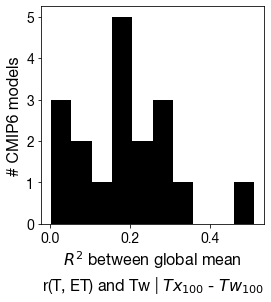

In [116]:
plt.figure(figsize=(4,4))
plt.hist(cmip6_tw_tx_minus_tw_tw_r2, color='k')

plt.ylabel('# CMIP6 models')
plt.xlabel('$R^2$ between global mean\nr(T, ET) and Tw | $Tx_{100}$ - $Tw_{100}$')

In [63]:
cmip6_tx_tw_corr_detrend_norm = cmip6_tx_tw_corr_detrend-np.nanmean(cmip6_tx_tw_corr_detrend, axis=0)
cmip6_tw_tx_minus_tw_tw_detrend_norm = cmip6_tw_tx_minus_tw_tw_detrend-np.nanmean(cmip6_tw_tx_minus_tw_tw_detrend, axis=0)
cmip6_tx_tw_minus_tx_tx_detrend_norm = cmip6_tx_tw_minus_tx_tx_detrend-np.nanmean(cmip6_tx_tw_minus_tx_tx_detrend, axis=0)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


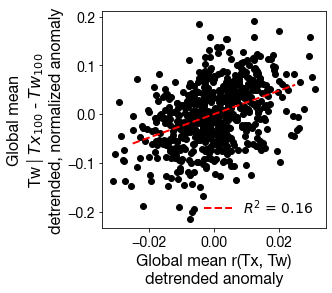

In [64]:
x_all = cmip6_tx_tw_corr_detrend_norm.reshape([cmip6_tx_tw_corr_detrend_norm.size])
y_all = cmip6_tw_tx_minus_tw_tw_detrend_norm.reshape([cmip6_tw_tx_minus_tw_tw_detrend_norm.size])
X = sm.add_constant(x_all)
mdl = sm.OLS(y_all, X).fit()

x1 = -.025
x2 = 0.025

plt.figure(figsize=(4,4))
plt.scatter(x_all, y_all, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTw | $Tx_{100}$ - $Tw_{100}$\ndetrended, normalized anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

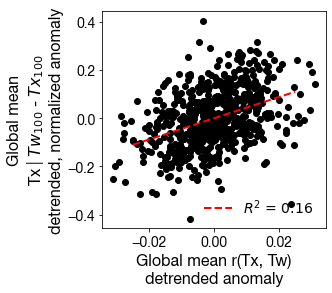

In [59]:
x_all = cmip6_tx_tw_corr_detrend_norm.reshape([cmip6_tx_tw_corr_detrend_norm.size])
y_all = cmip6_tx_tw_minus_tx_tx_detrend_norm.reshape([cmip6_tx_tw_minus_tx_tx_detrend_norm.size])
X = sm.add_constant(x_all)
mdl = sm.OLS(y_all, X).fit()

x1 = -.025
x2 = 0.025

plt.figure(figsize=(4,4))
plt.scatter(x_all, y_all, c='k')
plt.plot([x1,x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--r', lw=2, label='$R^2$ = %.2f'%mdl.rsquared)

plt.xlabel('Global mean r(Tx, Tw)\ndetrended anomaly')
# plt.xticks([.48, .5, .52, .54])
plt.ylabel('Global mean\nTx | $Tw_{100}$ - $Tx_{100}$\ndetrended, normalized anomaly')
font = FontProperties(family='Arial', size=14)
plt.legend(frameon=False, fontsize=14, prop=font)

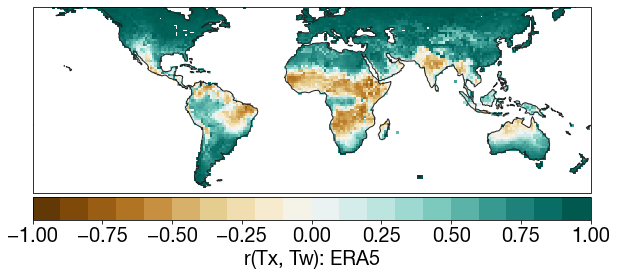

In [61]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = tx_tw_corr_mean_regrid

c = plt.pcolormesh(tx_tw_corr_mean_regrid.lon, tx_tw_corr_mean_regrid.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


AttributeError: 'Dataset' object has no attribute 'lon'

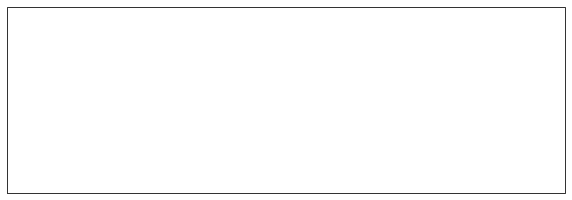

In [62]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -1
v2 = 1.1
vstep = .1
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


AttributeError: 'Dataset' object has no attribute 'lon'

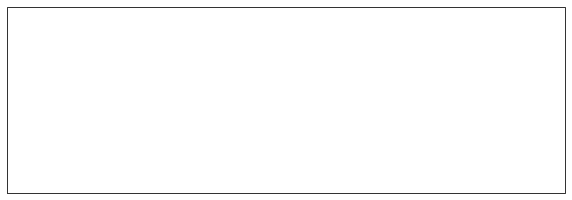

In [63]:

plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.5
v2 = .51
vstep = .05
vlabelstep = .1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = corr_spatial.tx_tw_corr.mean(dim=['model', 'year']).values - tx_tw_corr_mean_regrid

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean - ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


Text(0, 0.5, 'Global mean\nr(Tx, Tw) trend\n(per decade)')

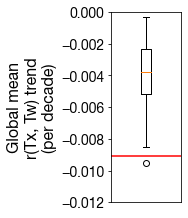

In [65]:
plt.figure(figsize=(1.25,3.5))
plt.ylim([-.012, 0])
plt.boxplot(corr_ts_slopes)
plt.plot([.5, 1.5], [obs_slope, obs_slope], '-r')
plt.xticks([])
plt.ylabel('Global mean\nr(Tx, Tw) trend\n(per decade)')

In [65]:
np.where(np.array(corr_ts_pvals)<.05)[0].size,np.array(corr_ts_pvals).size

(8, 18)

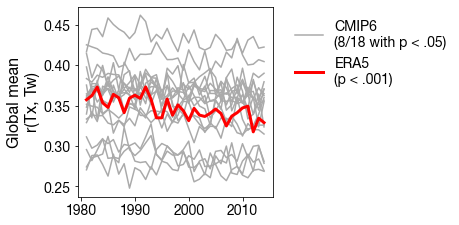

In [66]:
plt.figure(figsize=(3.5,3.5))
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[0,0:34].T, c='#aaaaaa', label='CMIP6\n(8/18 with p < .05)')
plt.plot(tx_tw_corr_ts.time.dt.year.values, corr_ts[1:,0:34].T, c='#aaaaaa')
plt.plot(tx_tw_corr_ts.time.dt.year.values, tx_tw_corr_ts.tx_tw_corr, c='r', lw=3, label='ERA5\n(p < .001)')
plt.xticks([1980, 1990, 2000, 2010])
plt.ylabel('Global mean\nr(Tx, Tw)')
l = plt.legend(fontsize=14, framealpha=.75, bbox_to_anchor=(1.05, 1.0), loc='upper left')
l.get_frame().set_linewidth(0)

In [67]:
# CALC SPATIAL TREND IN CORR

from datetime import datetime
def add_time_dim(xda):
    xda = xda.expand_dims(time = [datetime.now()])
    return xda

time_dim = pd.date_range("1981-01-01", "2021-12-31", freq="AS")
cmip6_var = xr.open_dataset('tx_tw_corr_%s.nc'%cmip6_models[0])
cmip6_var = cmip6_var.rename({'__xarray_dataarray_variable__':'tx_tw_corr'})
cmip6_var['year'] = time_dim
cmip6_var = cmip6_var.chunk(chunks={"year": -1, "lat": 50, "lon": 50})
cmip6_var = cmip6_var.chunk({"year": -1})
# era5_var_deciles = era5_var_deciles.chunk({"quantile": -1})

ValueError: conflicting sizes for dimension 'year': length 34 on 'tx_tw_corr' and length 41 on 'year'

In [91]:

def linregress_ufunc(x, y):
    # Remove rows where either x or y is nan
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    # If all values are nan or the length of x, y are less than 2, return nan
    if len(x) < 2 or len(y) < 2:
        return (np.nan, np.nan)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return slope, p_value

# rest of the code remains the same


def apply_trend_and_pvalue(ds, time_dim='year', x_dim='lon', y_dim='lat'):
    # Extract the year information from the time coordinates
    time_years = ds[time_dim].dt.year.values
    unique_years = np.unique(time_years)
    
    # Broadcast unique_years along the time dimension
    unique_years_broadcasted = xr.DataArray(unique_years, dims=[time_dim], coords={time_dim: ds[time_dim]})
    
    trend, p_value = xr.apply_ufunc(
        linregress_ufunc,
        unique_years_broadcasted,
        ds,
        input_core_dims=[[time_dim], [time_dim]],
        output_core_dims=[[], []],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float, float]
    )

    trend = trend.rename("tx_tw_corr_trend")
    p_value = p_value.rename("tx_tw_corr_trend_p_value")
    
    return xr.merge([trend, p_value])





In [92]:
cmip6_var_trend = apply_trend_and_pvalue(cmip6_var['tx_tw_corr'])

In [93]:
client = Client()

In [94]:
cmip6_var_trend.compute()

<xarray.Dataset>
Dimensions:                   (lat: 81, lon: 240)
Coordinates:
  * lat                       (lat) float64 -60.0 -58.5 -57.0 ... 57.0 58.5 60.0
    height                    float64 2.0
  * lon                       (lon) float64 0.0 1.5 3.0 ... 355.5 357.0 358.5
Data variables:
    tx_tw_corr_trend          (lat, lon) float64 nan nan nan nan ... nan nan nan
    tx_tw_corr_trend_p_value  (lat, lon) float64 nan nan nan nan ... nan nan nan

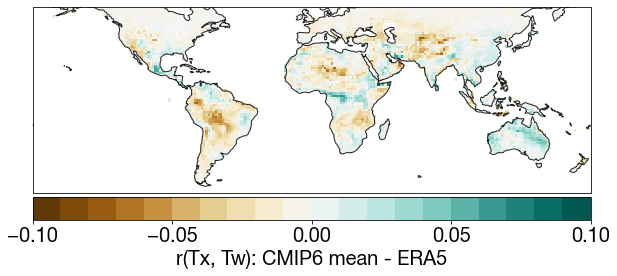

In [100]:
plt.figure(figsize=(10,8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, -180, 60, -60])

v1 = -.1
v2 = .11
vstep = .01
vlabelstep = .05
midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)
cmap = plt.cm.get_cmap('BrBG')

data = cmip6_var_trend.tx_tw_corr_trend.values*10

c = plt.pcolormesh(cur_tx_tw_corr.lon, cur_tx_tw_corr.lat, data, \
                 cmap=cmap, norm=midnorm)

ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')

# plt.text(-125, -30, 'Mean: %.1f'%(np.nanmean(data)), fontdict={'family':'helvetica', 'size':16}, ha='center', va='center')
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('r(Tx, Tw): CMIP6 mean - ERA5', fontsize=20)

# plt.savefig('t-et-era5-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)
